### Image Classification on MNIST and EMNIST Letters

#### Summary of Techniques
- inspired by what Nelsen mentioned the paper in 2010 by Ciresan, Meier, Gambardella, and Schmidhuber they used 
only fully-connected layers (no convolutions). Here we used 2 convnet plus added more than 2 fully connected layers 
with many epoches (196 epoches) of training time.
- 0.5 dropout in between each fully connected layers;
- did not apply dropout to convolution layers since according to Nelsen, the convolutional layers have consideralbe
inbuilt resistance to overfitting.
- applied Batch normalization for each layer in between to solve the potential vanishing gradient problem and
potentially dead ReLu problem. 
- employed early stopping, it shows the network was keep learning so it did not reach to the point of early stopping,
so it stops when all data are consumed.
- Used optimizer=keras.optimizers.Adadelta() rather than SGD in Keras. The advantage for Adadelta is it can 
automaticaly update learning rate adaptively of its learning rate according to loss function. 
- We tested on SGD with eta=0.03 which produced very low test accuracy.
- Expanded training dataset using Keras ImageDataGenerator() in MNIST dataset (see iteration 12). 
It did not help with model accuracy improvement. It might help in theory with the right parameters for data augmentation.
- The fully connected layers with dropout helps gradually reduce over-fitting (better performance than fewer layers high 
droput)
- added save the model to local disk to load in the future to re-produce the result
- Used Relu activation, but it might have dead ReLu problem according to Standard CNN class. It worthy to try Leaky Relu.
- displayed random chosen mis-classified hand writing letters
- displayed accuracy and loss in TensorBoard
- relatively larger batch size helps with model performance.

#### Summary of Accuracy on MNIST
- training accuracy: 99.92%
- validation accuracy: 99.60%
- test accuracy: 99.48%

#### Summary of Accuracy on EMNIST
- training accuracy: 98.7%
- validation accuracy: 95.1%
- test accuracy: 94.9%

In [1]:
from __future__ import print_function
import keras
from keras import backend as K
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
#from keras.preprocessing.image import ImageDataGenerator

from keras.callbacks import EarlyStopping
from matplotlib import pyplot
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

from scipy import io as sio
import numpy as np
import gzip
from time import time
from keras.callbacks import TensorBoard

import matplotlib.pyplot as plt
import cv2
import random

Using TensorFlow backend.


In [2]:
# different backend has different requirement to input dimensions
# which is 4 dimensional tensor for Tensorflow with channels_last
# (samples, rows, cols, channels) 
print(K.image_data_format()) 

channels_last


## Warm Up

#### 1. Try running mnist_cnn.py and verify that you can match the accuracy of 99.25% claimed in the comments
Summary of result: 
- training accuracy: 0.9922
- test accuracy (on test dataset): 0.9912

In [2]:
batch_size = 128
num_classes = 10
epochs = 12

# input image dimensions
img_rows, img_cols = 28, 28

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()
print(x_train.shape,y_train.shape,x_test.shape,y_test.shape)

(60000, 28, 28) (60000,) (10000, 28, 28) (10000,)


In [2]:
#  TensorFlow's tensor expect the input shape (samples, rows, cols, channels) 

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Train on 60000 samples, validate on 10000 samples
Epoch 1/12
60000/60000 [==============================] - 120s 2ms/step - loss: 0.2729 - acc: 0.9150 - val_loss: 0.0632 - val_acc: 0.9800
Epoch 2/12
60000/60000 [==============================] - 119s 2ms/step - loss: 0.0891 - acc: 0.9743 - val_loss: 0.0427 - val_acc: 0.9865
Epoch 3/12
60000/60000 [==============================] - 121s 2ms/step - loss: 0.0672 - acc: 0.9795 - val_loss: 0.0329 - val_acc: 0.9890
Epoch 4/12
60000/60000 [==============================] - 122s 2ms/step - loss: 0.0532 - acc: 0.9844 - val_loss: 0.0319 - val_acc: 0.9897
Epoch 5/12
60000/60000 [==============================] - 121s 2ms/step - loss: 0.0459 - a

### Nielsen claims an accuracy of 99.60% for the last model in Chapter 6 (see Inserting an extra fully-connected layer). Modify mnist_cnn.py to match the parameters of that model, and compare your results.

##### add one extra layer based on Nielsen's network3 pipeline - iteration 1
Summary of result:
- training accuracy: 0.9971
- test accuracy: 0.9912
- added extra fully connected layer

In [2]:
batch_size = 128
num_classes = 10
epochs = 12

# input image dimensions
img_rows, img_cols = 28, 28

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()
print(x_train.shape,y_train.shape,x_test.shape,y_test.shape)

(60000, 28, 28) (60000,) (10000, 28, 28) (10000,)


In [3]:
#  TensorFlow's tensor expect the input shape (samples, rows, cols, channels) 

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices (one hot encoding)
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu')) 
# added one extra fully connected layer below
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Train on 60000 samples, validate on 10000 samples
Epoch 1/12
60000/60000 [==============================] - 132s 2ms/step - loss: 0.2777 - acc: 0.9147 - val_loss: 0.0568 - val_acc: 0.9819
Epoch 2/12
60000/60000 [==============================] - 127s 2ms/step - loss: 0.0720 - acc: 0.9796 - val_loss: 0.0488 - val_acc: 0.9846
Epoch 3/12
60000/60000 [==============================] - 128s 2ms/step - loss: 0.0503 - acc: 0.9859 - val_loss: 0.0368 - val_acc: 0.9889
Epoch 4/12
60000/60000 [==============================] - 126s 2ms/step - loss: 0.0404 - acc: 0.9881 - val_loss: 0.0311 - val_acc: 0.9902
Epoch 5/12
60000/60000 [==============================] - 129s 2ms/step - loss: 0.0312 - a

##### add one extra layer based on Nielsen's network3 pipeline- iteration 2 
Summary of Result:
- optimizer=keras.optimizers.Adadelta(), Nieselsen used SGD for optimizer but SGD in Keras did not perform well
- training accuracy: 0.9993
- test accuracy: 0.9941

In [9]:
batch_size = 10
num_classes = 10
epochs = 40

# input image dimensions
img_rows, img_cols = 28, 28

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()
print(x_train.shape,y_train.shape,x_test.shape,y_test.shape)

(60000, 28, 28) (60000,) (10000, 28, 28) (10000,)


In [10]:
#  TensorFlow's tensor expect the input shape (samples, rows, cols, channels) 

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

model = Sequential()
model.add(Conv2D(20, kernel_size=(5, 5),
                 activation='relu',
                 input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(40, (5, 5), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
#model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(1000, activation='relu')) 
model.add(Dropout(0.5))
# added one extra fully connected layer below
model.add(Dense(1000, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples
Train on 60000 samples, validate on 10000 samples
Epoch 1/40
60000/60000 [==============================] - 221s 4ms/step - loss: 0.1323 - acc: 0.9603 - val_loss: 0.0610 - val_acc: 0.9817
Epoch 2/40
60000/60000 [==============================] - 218s 4ms/step - loss: 0.0545 - acc: 0.9849 - val_loss: 0.0337 - val_acc: 0.9908
Epoch 3/40
60000/60000 [==============================] - 211s 4ms/step - loss: 0.0450 - acc: 0.9885 - val_loss: 0.0348 - val_acc: 0.9899
Epoch 4/40
60000/60000 [==============================] - 207s 3ms/step - loss: 0.0365 - acc: 0.9902 - val_loss: 0.0354 - val_acc: 0.9914
Epoch 5/40
60000/60000 [==============================] - 208s 3ms/step - loss: 0.0321 - acc: 0.9919 - val_loss: 0.0468 - val_acc: 0.9895
Epoch 6/40
60000/60000 [==============================] - 209s 3ms/step - loss: 0.0286 - acc: 0.9929 - val_loss: 0.0336 - val_acc: 0.9924
Epoch 7/40
60000/60000 [=========================

##### add one extra layer based on Nielsen's network3 pipeline- iteration 13
- Summary of result:
    - training accuracy: 99.92%
    - validation accuracy: 99.60%
    - test accuracy: 99.48%
- Summary of parameters and hyper-parameters
    - inspired by Nelsen's mentioned a paper, we used 4 fully connected layers with many epoches (196) of training time.
     - 0.5 dropout for fully connected layers
     - Batch normalization for each layer in between to solve the potential vanishing gradient problem.
     - no preprocessing, as it did not help in improving the accuracy

In [2]:
batch_size = 249 #784
num_classes = 10
epochs = 196

# input image dimensions
img_rows, img_cols = 28, 28

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()
# the data, split between train and validation sets
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size = 0.167, random_state = 0, shuffle=True)
# x_train, y_train = shuffle(x_train, y_train)
print(x_train.shape,y_train.shape,x_valid.shape,y_valid.shape,x_test.shape,y_test.shape)

(49980, 28, 28) (49980,) (10020, 28, 28) (10020,) (10000, 28, 28) (10000,)


In [3]:
# TensorFlow's tensor expect the input shape (samples, rows, cols, channels) 
if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_valid = x_valid.reshape(x_valid.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_valid = x_valid.reshape(x_valid.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

# normalize the input data for reducing over-fitting
x_train = x_train.astype('float32')
x_valid = x_valid.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_valid /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')


# convert class vectors to ont hot encoding
y_train = keras.utils.to_categorical(y_train, num_classes,dtype='float32')
y_valid = keras.utils.to_categorical(y_valid, num_classes,dtype='float32')
y_test = keras.utils.to_categorical(y_test, num_classes,dtype='float32')

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(BatchNormalization(axis=-1))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization(axis=-1))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))
model.add(Flatten())
# model.add(Dense(128, activation='relu'))
model.add(Dense(1568, activation='relu'))
model.add(BatchNormalization(axis=-1))
model.add(Dropout(0.5))
model.add(Dense(1000, activation='relu'))
model.add(BatchNormalization(axis=-1))
model.add(Dropout(0.5))
model.add(Dense(700, activation='relu'))
model.add(BatchNormalization(axis=-1))
model.add(Dropout(0.5))
model.add(Dense(300, activation='relu'))
model.add(BatchNormalization(axis=-1))
model.add(Dropout(0.5))
model.add(Dense(100, activation='relu'))
model.add(BatchNormalization(axis=-1))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])
tensorboard = TensorBoard(log_dir="logs_mnist_13/{}".format(time()))
# simple early stopping
es = EarlyStopping(monitor='val_acc', mode='max', verbose=1)
history= model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          callbacks=[tensorboard],
          validation_data=(x_valid, y_valid))

score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0]*100,'%')
print('Test accuracy:', score[1]*100,'%')
model.save('mnist_v13.h5')
print('saved model to disk')

x_train shape: (49980, 28, 28, 1)
49980 train samples
49980 train samples
10000 test samples
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Train on 49980 samples, validate on 10020 samples
Epoch 1/196
49980/49980 [==============================] - 80s 2ms/step - loss: 0.4506 - acc: 0.8595 - val_loss: 0.0840 - val_acc: 0.9778
Epoch 2/196
49980/49980 [==============================] - 73s 1ms/step - loss: 0.1232 - acc: 0.9629 - val_loss: 0.0550 - val_acc: 0.9845
Epoch 3/196
49980/49980 [==============================] - 77s 2ms/step - loss: 0.0868 - acc: 0.9740 - val_loss: 0.0381 - val_acc: 0.9875
Epoch 4/196
49980/49980 [==============================] - 75s 2ms/step - loss: 0.0725 - acc: 0.9784 - val_loss: 0.0316 - val_acc: 0.9911
Epoch 5/196
49980/49980 [==============================] - 73s 1ms/ste

Epoch 111/196
49980/49980 [==============================] - 73s 1ms/step - loss: 0.0046 - acc: 0.9985 - val_loss: 0.0254 - val_acc: 0.9956
Epoch 112/196
49980/49980 [==============================] - 73s 1ms/step - loss: 0.0044 - acc: 0.9987 - val_loss: 0.0275 - val_acc: 0.9955
Epoch 113/196
49980/49980 [==============================] - 73s 1ms/step - loss: 0.0043 - acc: 0.9986 - val_loss: 0.0259 - val_acc: 0.9957
Epoch 114/196
49980/49980 [==============================] - 73s 1ms/step - loss: 0.0041 - acc: 0.9985 - val_loss: 0.0263 - val_acc: 0.9953
Epoch 115/196
49980/49980 [==============================] - 73s 1ms/step - loss: 0.0042 - acc: 0.9987 - val_loss: 0.0260 - val_acc: 0.9955
Epoch 116/196
49980/49980 [==============================] - 73s 1ms/step - loss: 0.0056 - acc: 0.9982 - val_loss: 0.0263 - val_acc: 0.9955
Epoch 117/196
49980/49980 [==============================] - 73s 1ms/step - loss: 0.0044 - acc: 0.9986 - val_loss: 0.0249 - val_acc: 0.9958
Epoch 118/196
49980/

In [4]:
# evaluate the model
_, train_acc = model.evaluate(x_train, y_train, verbose=0)
_, valid_acc = model.evaluate(x_valid, y_valid, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, valid_acc))

_, test_acc = model.evaluate(x_test, y_test, verbose=0)
print('Test: %.3f' % (test_acc))

Train: 1.000, Test: 0.996
Test: 0.995


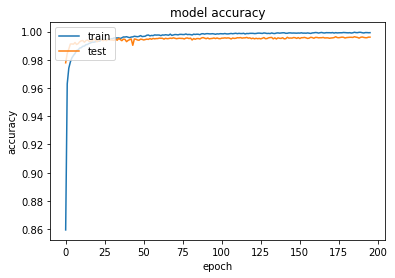

In [5]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

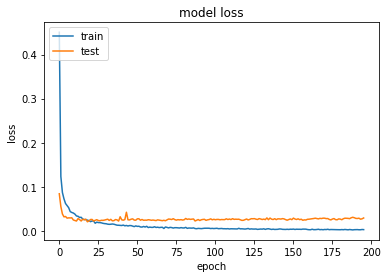

In [6]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Preprocess letters and mergere with training set, retrain (iteration 12)

In [2]:
# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()
print(x_train.shape, y_train.shape)
# input image dimensions
img_rows, img_cols = 28, 28
x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
print(x_train.shape)

(60000, 28, 28) (60000,)
(60000, 1, 28, 28)


In [3]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

x_preprocessed = []
y_preprocessed = []
datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
        )

# img = load_img('data/train/cats/cat.0.jpg')  # this is a PIL image
# x = img_to_array(img)  # this is a Numpy array with shape (3, 150, 150)
# x = x.reshape((1,) + x.shape)  # this is a Numpy array with shape (1, 3, 150, 150)

# the .flow() command below generates batches of randomly transformed images
# and saves the results to the `preprocessed/` directory
i = 0
for x,y in datagen.flow(x_train,y=y_train, batch_size=1):
    x_preprocessed.append(x)
    y_preprocessed.append(y)
    i += 1
    if i > 10000:
        break  # otherwise the generator would loop indefinitely

C:\Users\CampusUser\Anaconda3\envs\Keras\lib\site-packages\keras_preprocessing\image\numpy_array_iterator.py:127: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (60000, 1, 28, 28) (28 channels).
  str(self.x.shape[channels_axis]) + ' channels).')


In [4]:
x_preprocessed = np.array(x_preprocessed)
y_preprocessed = np.array(y_preprocessed)
print(x_preprocessed.shape,y_preprocessed.shape)

x_preprocessed = x_preprocessed.reshape(x_preprocessed.shape[0], img_rows, img_cols)
y_preprocessed = y_preprocessed.reshape(y_preprocessed.shape[0])
print(x_preprocessed.shape,y_preprocessed.shape)

x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols)

x_train = np.concatenate((x_train,x_preprocessed),axis=0)
y_train = np.concatenate((y_train,y_preprocessed),axis=0)
print(x_train.shape,y_train.shape)

(10001, 1, 1, 28, 28) (10001, 1)
(10001, 28, 28) (10001,)
(70001, 28, 28) (70001,)


In [113]:
# the data, split between train and validation sets
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size = 0.14, random_state = 0, shuffle=True)
# x_train, y_train = shuffle(x_train, y_train)
print(x_train.shape,y_train.shape,x_valid.shape,y_valid.shape,x_test.shape,y_test.shape)

(60200, 28, 28) (60200,) (9801, 28, 28) (9801,) (10000, 28, 28) (10000,)


In [114]:
batch_size = 249 #784
num_classes = 10
epochs = 281

In [115]:
# TensorFlow's tensor expect the input shape (samples, rows, cols, channels) 
if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_valid = x_valid.reshape(x_valid.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_valid = x_valid.reshape(x_valid.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

# normalize the input data for reducing over-fitting
x_train = x_train.astype('float32')
x_valid = x_valid.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_valid /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')


# convert class vectors to ont hot encoding
y_train = keras.utils.to_categorical(y_train, num_classes,dtype='float32')
y_valid = keras.utils.to_categorical(y_valid, num_classes,dtype='float32')
y_test = keras.utils.to_categorical(y_test, num_classes,dtype='float32')

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(BatchNormalization(axis=-1))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization(axis=-1))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))
model.add(Flatten())
# model.add(Dense(128, activation='relu'))
model.add(Dense(1568, activation='relu'))
model.add(BatchNormalization(axis=-1))
model.add(Dropout(0.5))
model.add(Dense(1000, activation='relu'))
model.add(BatchNormalization(axis=-1))
model.add(Dropout(0.5))
model.add(Dense(700, activation='relu'))
model.add(BatchNormalization(axis=-1))
model.add(Dropout(0.5))
model.add(Dense(300, activation='relu'))
model.add(BatchNormalization(axis=-1))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])
tensorboard = TensorBoard(log_dir="logs_mnist_11/{}".format(time()))
# simple early stopping
es = EarlyStopping(monitor='val_acc', mode='max', verbose=1)
history= model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          callbacks=[tensorboard],
          validation_data=(x_valid, y_valid))

score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0]*100,'%')
print('Test accuracy:', score[1]*100,'%')
model.save('mnist_v11.h5')
print('saved model to disk')

x_train shape: (60200, 28, 28, 1)
60200 train samples
60200 train samples
10000 test samples
Train on 60200 samples, validate on 9801 samples
Epoch 1/281
60200/60200 [==============================] - 136s 2ms/step - loss: 0.4738 - acc: 0.8534 - val_loss: 0.1954 - val_acc: 0.9431
Epoch 2/281
60200/60200 [==============================] - 129s 2ms/step - loss: 0.1999 - acc: 0.9360 - val_loss: 0.1212 - val_acc: 0.9626
Epoch 3/281
60200/60200 [==============================] - 97s 2ms/step - loss: 0.1486 - acc: 0.9525 - val_loss: 0.0890 - val_acc: 0.9727
Epoch 4/281
60200/60200 [==============================] - 92s 2ms/step - loss: 0.1217 - acc: 0.9615 - val_loss: 0.0758 - val_acc: 0.9765
Epoch 5/281
60200/60200 [==============================] - 88s 1ms/step - loss: 0.1058 - acc: 0.9665 - val_loss: 0.0622 - val_acc: 0.9802
Epoch 6/281
60200/60200 [==============================] - 87s 1ms/step - loss: 0.0905 - acc: 0.9714 - val_loss: 0.0672 - val_acc: 0.9780
Epoch 7/281
60200/60200 [===

Epoch 59/281
60200/60200 [==============================] - 87s 1ms/step - loss: 0.0144 - acc: 0.9950 - val_loss: 0.0409 - val_acc: 0.9898
Epoch 60/281
60200/60200 [==============================] - 88s 1ms/step - loss: 0.0162 - acc: 0.9949 - val_loss: 0.0469 - val_acc: 0.9889
Epoch 61/281
60200/60200 [==============================] - 87s 1ms/step - loss: 0.0153 - acc: 0.9948 - val_loss: 0.0394 - val_acc: 0.9900
Epoch 62/281
60200/60200 [==============================] - 88s 1ms/step - loss: 0.0149 - acc: 0.9951 - val_loss: 0.0428 - val_acc: 0.9890
Epoch 63/281
60200/60200 [==============================] - 87s 1ms/step - loss: 0.0155 - acc: 0.9947 - val_loss: 0.0488 - val_acc: 0.9883
Epoch 64/281
60200/60200 [==============================] - 87s 1ms/step - loss: 0.0145 - acc: 0.9950 - val_loss: 0.0428 - val_acc: 0.9894
Epoch 65/281
60200/60200 [==============================] - 87s 1ms/step - loss: 0.0131 - acc: 0.9955 - val_loss: 0.0401 - val_acc: 0.9900
Epoch 66/281
60200/60200 [=

Epoch 118/281
60200/60200 [==============================] - 87s 1ms/step - loss: 0.0094 - acc: 0.9969 - val_loss: 0.0452 - val_acc: 0.9901
Epoch 119/281
60200/60200 [==============================] - 88s 1ms/step - loss: 0.0078 - acc: 0.9974 - val_loss: 0.0459 - val_acc: 0.9901
Epoch 120/281
60200/60200 [==============================] - 87s 1ms/step - loss: 0.0096 - acc: 0.9966 - val_loss: 0.0533 - val_acc: 0.9892
Epoch 121/281
60200/60200 [==============================] - 88s 1ms/step - loss: 0.0078 - acc: 0.9975 - val_loss: 0.0421 - val_acc: 0.9905
Epoch 122/281
60200/60200 [==============================] - 87s 1ms/step - loss: 0.0083 - acc: 0.9971 - val_loss: 0.0451 - val_acc: 0.9899
Epoch 123/281
60200/60200 [==============================] - 87s 1ms/step - loss: 0.0076 - acc: 0.9975 - val_loss: 0.0409 - val_acc: 0.9900
Epoch 124/281
60200/60200 [==============================] - 87s 1ms/step - loss: 0.0082 - acc: 0.9973 - val_loss: 0.0454 - val_acc: 0.9903
Epoch 125/281
60200/

60200/60200 [==============================] - 88s 1ms/step - loss: 0.0050 - acc: 0.9983 - val_loss: 0.0487 - val_acc: 0.9906
Epoch 235/281
60200/60200 [==============================] - 87s 1ms/step - loss: 0.0046 - acc: 0.9983 - val_loss: 0.0483 - val_acc: 0.9905
Epoch 236/281
60200/60200 [==============================] - 87s 1ms/step - loss: 0.0047 - acc: 0.9985 - val_loss: 0.0495 - val_acc: 0.9909
Epoch 237/281
60200/60200 [==============================] - 87s 1ms/step - loss: 0.0047 - acc: 0.9984 - val_loss: 0.0501 - val_acc: 0.9904
Epoch 238/281
60200/60200 [==============================] - 87s 1ms/step - loss: 0.0036 - acc: 0.9987 - val_loss: 0.0454 - val_acc: 0.9911
Epoch 239/281
60200/60200 [==============================] - 91s 2ms/step - loss: 0.0051 - acc: 0.9984 - val_loss: 0.0508 - val_acc: 0.9907
Epoch 240/281
60200/60200 [==============================] - 88s 1ms/step - loss: 0.0040 - acc: 0.9986 - val_loss: 0.0481 - val_acc: 0.9911
Epoch 241/281
60200/60200 [=======

In [116]:
# evaluate the model
_, train_acc = model.evaluate(x_train, y_train, verbose=0)
_, valid_acc = model.evaluate(x_valid, y_valid, verbose=0)
print('Train: %.3f, Evaluate: %.3f' % (train_acc, valid_acc))

Train: 1.000, Evaluate: 0.991


In [119]:
_, test_acc = model.evaluate(x_test, y_test, verbose=0)
print('Test dataset accuracy: %.3f' % (test_acc))

Test dataset accuracy: 0.994


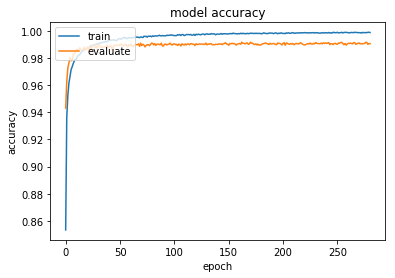

In [117]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'evaluate'], loc='upper left')
plt.show()

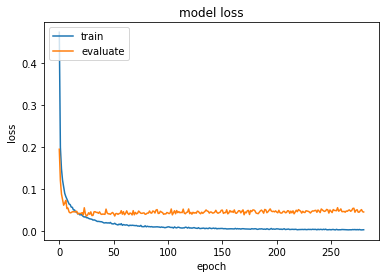

In [118]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'evaluate'], loc='upper left')
plt.show()

##### add one extra layer based on Nielsen's network3 pipeline- iteration 4
add one extra layer - iteration 3, batch_size = 20
epochs = 60 fully conncted layer=1000 nodes for 2 layers eta = 0.03 added regulatizer 
###### training accuracy: 0.9950, test accuracy: 0.9916

In [4]:
batch_size = 100
num_classes = 20
epochs = 60

# input image dimensions
img_rows, img_cols = 28, 28

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()
print(x_train.shape,y_train.shape,x_test.shape,y_test.shape)

(60000, 28, 28) (60000,) (10000, 28, 28) (10000,)


In [5]:
#  TensorFlow's tensor expect the input shape (samples, rows, cols, channels) 
from keras import regularizers

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

model = Sequential()
model.add(Conv2D(20, kernel_size=(5, 5),
                 activation='relu',
                 input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(40, (5, 5), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
#model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(1000, kernel_regularizer=regularizers.l2(0.01), activation='relu')) 
#model.add(Dropout(0.5))
# added one extra fully connected layer below
model.add(Dense(1000, kernel_regularizer=regularizers.l2(0.01), activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples
Train on 60000 samples, validate on 10000 samples
Epoch 1/60
60000/60000 [==============================] - 89s 1ms/step - loss: 1.5290 - acc: 0.9096 - val_loss: 0.2771 - val_acc: 0.9471
Epoch 2/60
60000/60000 [==============================] - 88s 1ms/step - loss: 0.1892 - acc: 0.9698 - val_loss: 0.1249 - val_acc: 0.9836
Epoch 3/60
60000/60000 [==============================] - 87s 1ms/step - loss: 0.1333 - acc: 0.9781 - val_loss: 0.1110 - val_acc: 0.9794
Epoch 4/60
60000/60000 [==============================] - 91s 2ms/step - loss: 0.1096 - acc: 0.9816 - val_loss: 0.0886 - val_acc: 0.9863
Epoch 5/60
60000/60000 [==============================] - 87s 1ms/step - loss: 0.0951 - acc: 0.9843 - val_loss: 0.0892 - val_acc: 0.9841
Epoch 6/60
60000/60000 [==============================] - 88s 1ms/step - loss: 0.0872 - acc: 0.9855 - val_loss: 0.0680 - val_acc: 0.9895
Epoch 7/60
60000/60000 [==============================]

##### add one extra layer based on Nielsen's network3 pipeline- iteration 5
- add BatchNormalization for every computation layer
- add one extra layer - iteration 3, batch_size = 20
- epochs = 60, fully conncted layer=1000 nodes for 2 layers eta = 0.03 added regulatizer 
- training accuracy: 0.9977,
- validation accuracy: 0.9924
- test accuracy: 0.9928

In [4]:
batch_size = 10
num_classes = 10
epochs = 40

# input image dimensions
img_rows, img_cols = 28, 28

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()
# # the data, split between train and validation sets
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size = 0.167, random_state = 0)
print(x_train.shape,y_train.shape,x_valid.shape,y_valid.shape,x_test.shape,y_test.shape)

(49980, 28, 28) (49980,) (10020, 28, 28) (10020,) (10000, 28, 28) (10000,)


In [5]:
# use data augmentation to reduce over-fitting
# gen = ImageDataGenerator(rotation_range=8, width_shift_range=0.08,shear_range=0.3,height_shift_range=0.08,zoom_range=0.08)
# valid_gen = ImageDataGenerator()

#  TensorFlow's tensor expect the input shape (samples, rows, cols, channels) 

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_valid = x_valid.reshape(x_valid.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_valid = x_valid.reshape(x_valid.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_valid = x_valid.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_valid /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_valid.shape[0], 'valid samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_valid = keras.utils.to_categorical(y_valid, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

# train_generator = gen.flow(x_train,y_train,batch_size=batch_size)
# valid_generator = valid_gen.flow(x_valid,y_valid,batch_size = batch_size)

model = Sequential()
model.add(Conv2D(20, kernel_size=(5, 5),
                 activation='relu',
                 input_shape=input_shape))
model.add(BatchNormalization(axis=-1))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(40, (5, 5), activation='relu'))
model.add(BatchNormalization(axis=-1))
model.add(MaxPooling2D(pool_size=(2, 2)))
#model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(2000, activation='relu')) 
model.add(BatchNormalization(axis=-1))
model.add(Dropout(0.3))
# added one extra fully connected layer below
model.add(Dense(1000, activation='relu'))
model.add(BatchNormalization(axis=-1))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              #optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_valid, y_valid))
# model.fit_generator(train_generator,steps_per_epoch=49980//batch_size,
#                    validation_data=valid_generator,validation_steps=10020//batch_size)
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

x_train shape: (49980, 28, 28, 1)
49980 train samples
10020 valid samples
10000 test samples
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Train on 49980 samples, validate on 10020 samples
Epoch 1/40
49980/49980 [==============================] - 324s 6ms/step - loss: 0.2364 - acc: 0.9370 - val_loss: 0.0660 - val_acc: 0.9800
Epoch 2/40
49980/49980 [==============================] - 373s 7ms/step - loss: 0.1004 - acc: 0.9732 - val_loss: 0.0366 - val_acc: 0.9888
Epoch 3/40
49980/49980 [==============================] - 309s 6ms/step - loss: 0.0728 - acc: 0.9801 - val_loss: 0.0374 - val_acc: 0.9883
Epoch 4/40
49980/49980 [==============================] - 318s 6ms/step - loss: 0.0591 - acc: 0.9841 - val_loss: 0.0375 - val_acc: 0.9903
Epoch 5/40
49980/49980 [==============================] - 309s 6ms/ste

## Training on EMNIST Letters

##### 1. Baseline Training on EMNIST letters (iteration 1)
- training accuracy: 93.72%
- test accuracy: 93.9%
- no train test split, validate directly on test dataset
- The following further iterations will do the train, valid, and test datasets split

In [2]:
from scipy import io as sio
import numpy as np
import gzip

In [4]:
#load dataset
mat = sio.loadmat('data/emnist-letters.mat')
data = mat['dataset']

In [5]:
# StackOverflow reference: 
# https://stackoverflow.com/questions/51125969/loading-emnist-letters-dataset/53547262#53547262
# There is an additional field 'writers' 
# (e.g. data['train'][0,0]['writers'][0,0]) that distinguishes the original sample writer. 
# The data['mapping'] field maps from class numbers to ASCII codes of the corresponding letters. 
# For example, class 1 maps to ASCII codes 65 and 97 ('A' and 'a'). 
X_train = data['train'][0,0]['images'][0,0]
y_train = data['train'][0,0]['labels'][0,0]
X_test = data['test'][0,0]['images'][0,0]
y_test = data['test'][0,0]['labels'][0,0]

In [6]:
print(X_train.shape[0],y_train.shape[0])

124800 124800


In [7]:
# reshape the data into 2D, 28x28 sized images instead of a 1D 784 array
# to get the correct image orientation you'll need to do a numpy reshape using Fortran ordering
# (Matlab uses column-major ordering, just like Fortran
# https://stackoverflow.com/questions/51125969/loading-emnist-letters-dataset/53547262#53547262
x_train = X_train.reshape((X_train.shape[0], 28, 28), order='F')
y_train = y_train.reshape(-1)
x_test = X_test.reshape((X_test.shape[0], 28, 28), order = 'F')   
y_test = y_test.reshape(-1)

In [8]:
print(x_train.shape,y_train.shape,x_test.shape,y_test.shape)

(124800, 28, 28) (124800,) (20800, 28, 28) (20800,)


In [9]:
# input image dimensions
img_rows, img_cols = 28, 28

In [10]:
# TensorFlow's tensor expect the input shape (samples, rows, cols, channels) 
if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)
    
batch_size = 654
num_classes = 27
epochs = 30

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes,dtype='float32')
y_test = keras.utils.to_categorical(y_test, num_classes,dtype='float32')

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])
tensorboard = TensorBoard(log_dir="logs/{}".format(time()))
model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          callbacks=[tensorboard],
          validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

x_train shape: (124800, 28, 28, 1)
124800 train samples
20800 test samples
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Train on 124800 samples, validate on 20800 samples
Epoch 1/30
124800/124800 [==============================] - 206s 2ms/step - loss: 1.2596 - acc: 0.6273 - val_loss: 0.4831 - val_acc: 0.8510
Epoch 2/30
124800/124800 [==============================] - 159s 1ms/step - loss: 0.5711 - acc: 0.8243 - val_loss: 0.3168 - val_acc: 0.8998
Epoch 3/30
124800/124800 [==============================] - 148s 1ms/step - loss: 0.4574 - acc: 0.8556 - val_loss: 0.2838 - val_acc: 0.9083
Epoch 4/30
124800/124800 [==============================] - 144s 1ms/step - loss: 0.4006 - acc: 0.8738 - val_loss: 0.2524 - val_acc: 0.9194
Epoch 5/30
124800/124800 [==============================] - 141s 1ms/step - los

#### 2. Training on EMNIST letters (iteration 5)
Split training dataset to training and validation datasets
test on test dataset
- training accuracy: 0.987
- validation accuracy: 0.951
- test accuracy: 0.949

In [12]:
from scipy import io as sio
import numpy as np
import gzip
from time import time
from keras.callbacks import TensorBoard

In [13]:
#load dataset
mat = sio.loadmat('data/emnist-letters.mat')
data = mat['dataset']
# https://stackoverflow.com/questions/51125969/loading-emnist-letters-dataset/53547262#53547262
X_train = data['train'][0,0]['images'][0,0]
y_train = data['train'][0,0]['labels'][0,0]
X_test = data['test'][0,0]['images'][0,0]
y_test = data['test'][0,0]['labels'][0,0]
# reshape the data into 2D, 28x28 sized images instead of a 1D 784 array
# to get the correct image orientation, need to do a numpy reshape using Fortran ordering
# (Matlab uses column-major ordering, just like Fortran
# https://stackoverflow.com/questions/51125969/loading-emnist-letters-dataset/53547262#53547262
x_train = X_train.reshape((X_train.shape[0], 28, 28), order='F')
y_train = y_train.reshape(-1)
x_test = X_test.reshape((X_test.shape[0], 28, 28), order = 'F')   
y_test = y_test.reshape(-1)
# the data, split between train and validation sets
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size = 0.167, random_state = 0, shuffle=True)
# we want to have the same size for valid and test
print(x_train.shape,y_train.shape, x_valid.shape,y_valid.shape,x_test.shape,y_test.shape)

(103958, 28, 28) (103958,) (20842, 28, 28) (20842,) (20800, 28, 28) (20800,)


In [14]:
batch_size = 249
num_classes = 27
epochs = 200
# input image dimensions
img_rows, img_cols = 28, 28

In [15]:
# TensorFlow's tensor expect the input shape (samples, rows, cols, channels) 
if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_valid = x_valid.reshape(x_valid.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_valid = x_valid.reshape(x_valid.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

# normalize the input data for reducing over-fitting
x_train = x_train.astype('float32')
x_valid = x_valid.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_valid /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_valid.shape[0], 'valid samples')
print(x_test.shape[0], 'test samples')


# convert class vectors to ont hot encoding
y_train = keras.utils.to_categorical(y_train, num_classes,dtype='float32')
y_valid = keras.utils.to_categorical(y_valid, num_classes,dtype='float32')
y_test = keras.utils.to_categorical(y_test, num_classes,dtype='float32')

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(BatchNormalization(axis=-1))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization(axis=-1))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))
model.add(Flatten())
# model.add(Dense(128, activation='relu'))
model.add(Dense(1568, activation='relu'))
model.add(BatchNormalization(axis=-1))
model.add(Dropout(0.5))
model.add(Dense(1000, activation='relu'))
model.add(BatchNormalization(axis=-1))
model.add(Dropout(0.5))
model.add(Dense(700, activation='relu'))
model.add(BatchNormalization(axis=-1))
model.add(Dropout(0.5))
model.add(Dense(300, activation='relu'))
model.add(BatchNormalization(axis=-1))
model.add(Dropout(0.5))
model.add(Dense(100, activation='relu'))
model.add(BatchNormalization(axis=-1))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])
tensorboard = TensorBoard(log_dir="logs_emnist_5/{}".format(time()))
# simple early stopping
es = EarlyStopping(monitor='val_acc', mode='max', verbose=1)
history= model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          callbacks=[tensorboard],
          validation_data=(x_valid, y_valid))

score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0]*100,'%')
print('Test accuracy:', score[1]*100,'%')
model.save('emnist_v5.h5')
print('saved model to disk')

# below part caused key errors, so moved down a cless to re-run the plotting
# it does not impact the training and evaluation parts
# evaluate the model
_, train_acc = model.evaluate(x_train, y_train, verbose=0)
_, valid_acc = model.evaluate(x_valid, y_valid, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, valid_acc))
# plot training history
pyplot.plot(history.history['accuracy'], label='train')
pyplot.plot(history.history['accuracy'], label='validation')
pyplot.legend()
pyplot.show()

x_train shape: (103958, 28, 28, 1)
103958 train samples
20842 valid samples
20800 test samples
Train on 103958 samples, validate on 20842 samples
Epoch 1/200
103958/103958 [==============================] - 164s 2ms/step - loss: 0.9631 - acc: 0.7058 - val_loss: 0.3359 - val_acc: 0.8931
Epoch 2/200
103958/103958 [==============================] - 158s 2ms/step - loss: 0.3938 - acc: 0.8718 - val_loss: 0.2416 - val_acc: 0.9208
Epoch 3/200
103958/103958 [==============================] - 153s 1ms/step - loss: 0.3132 - acc: 0.8967 - val_loss: 0.2147 - val_acc: 0.9294
Epoch 4/200
103958/103958 [==============================] - 152s 1ms/step - loss: 0.2825 - acc: 0.9061 - val_loss: 0.1981 - val_acc: 0.9337
Epoch 5/200
103958/103958 [==============================] - 153s 1ms/step - loss: 0.2595 - acc: 0.9144 - val_loss: 0.2144 - val_acc: 0.9293
Epoch 6/200
103958/103958 [==============================] - 153s 1ms/step - loss: 0.2402 - acc: 0.9191 - val_loss: 0.1909 - val_acc: 0.9373
Epoch 7/

Epoch 58/200
103958/103958 [==============================] - 153s 1ms/step - loss: 0.1101 - acc: 0.9588 - val_loss: 0.1597 - val_acc: 0.9498
Epoch 59/200
103958/103958 [==============================] - 158s 2ms/step - loss: 0.1095 - acc: 0.9596 - val_loss: 0.1619 - val_acc: 0.9489
Epoch 60/200
103958/103958 [==============================] - 153s 1ms/step - loss: 0.1097 - acc: 0.9593 - val_loss: 0.1656 - val_acc: 0.9494
Epoch 61/200
103958/103958 [==============================] - 153s 1ms/step - loss: 0.1076 - acc: 0.9604 - val_loss: 0.1652 - val_acc: 0.9490
Epoch 62/200
103958/103958 [==============================] - 154s 1ms/step - loss: 0.1083 - acc: 0.9593 - val_loss: 0.1605 - val_acc: 0.9492
Epoch 63/200
103958/103958 [==============================] - 153s 1ms/step - loss: 0.1058 - acc: 0.9603 - val_loss: 0.1615 - val_acc: 0.9502
Epoch 64/200
103958/103958 [==============================] - 153s 1ms/step - loss: 0.1060 - acc: 0.9604 - val_loss: 0.1636 - val_acc: 0.9495
Epoch 

103958/103958 [==============================] - 155s 1ms/step - loss: 0.0688 - acc: 0.9731 - val_loss: 0.1846 - val_acc: 0.9509
Epoch 173/200
103958/103958 [==============================] - 154s 1ms/step - loss: 0.0700 - acc: 0.9726 - val_loss: 0.1858 - val_acc: 0.9506
Epoch 174/200
103958/103958 [==============================] - 154s 1ms/step - loss: 0.0699 - acc: 0.9722 - val_loss: 0.1866 - val_acc: 0.9502
Epoch 175/200
103958/103958 [==============================] - 155s 1ms/step - loss: 0.0686 - acc: 0.9728 - val_loss: 0.1840 - val_acc: 0.9514
Epoch 176/200
103958/103958 [==============================] - 155s 1ms/step - loss: 0.0673 - acc: 0.9734 - val_loss: 0.1825 - val_acc: 0.9498
Epoch 177/200
103958/103958 [==============================] - 155s 1ms/step - loss: 0.0671 - acc: 0.9729 - val_loss: 0.1866 - val_acc: 0.9507
Epoch 178/200
103958/103958 [==============================] - 155s 1ms/step - loss: 0.0673 - acc: 0.9736 - val_loss: 0.1854 - val_acc: 0.9506
Epoch 179/200

KeyError: 'accuracy'

##### Rerun evaluate the model part as they key shall be "acc" for training accuracy (not accuracy), key for validation is "val_acc"

In [19]:
# evaluate the model
_, train_acc = model.evaluate(x_train, y_train, verbose=0)
_, valid_acc = model.evaluate(x_valid, y_valid, verbose=0)
print('Train: %.3f, evaluate: %.3f' % (train_acc, valid_acc))

_, test_acc = model.evaluate(x_test, y_test, verbose=0)
print('Test: %.3f' % (test_acc))

Train: 0.987, evaluate: 0.951
Test: 0.949


#### Q: When finished, evaluate your results on the test set. Compare the performance on the test set with your previous networks.

As in project 3, we employed deep neural networks. It is much faster to train to reach the 90%+ test accuracy with just several epochs. Compared with the project 2 where we employed MLP that we used many epochs and long time training, our model's final test accuracy is 85.98%.
In project 3 our final model test accuracy is above 95% and the speed of training is much faster than the one in project 2.

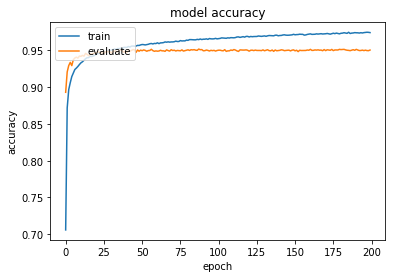

In [20]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'evaluate'], loc='upper left')
plt.show()

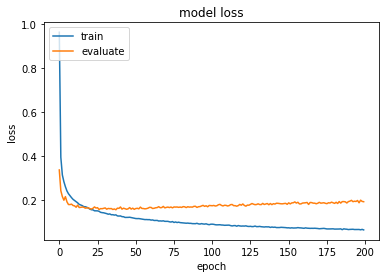

In [18]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'evaluate'], loc='upper left')
plt.show()

##### display some mis-classified images randomly (part 1)

In [21]:
# get the mis-classified images
miscla_index = []
y_prob = model.predict(x_test, verbose=0)
y_pred = y_prob.argmax(axis=-1)
y_real_label = y_test.argmax(axis=-1)
for i in range(len(y_real_label)):
    if y_pred[i] != y_real_label[i]:
        miscla_index.append(i)
print('number of misclassified is: ',len(miscla_index))

number of misclassified is:  1059


In [22]:
# used capatalized letter to represent both capatalized and small letters
y_classes = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26]  
y_labels = ['A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z']

displaying indexes are:  [7042, 6782, 12956, 5515, 16971, 8343, 2668, 9272]


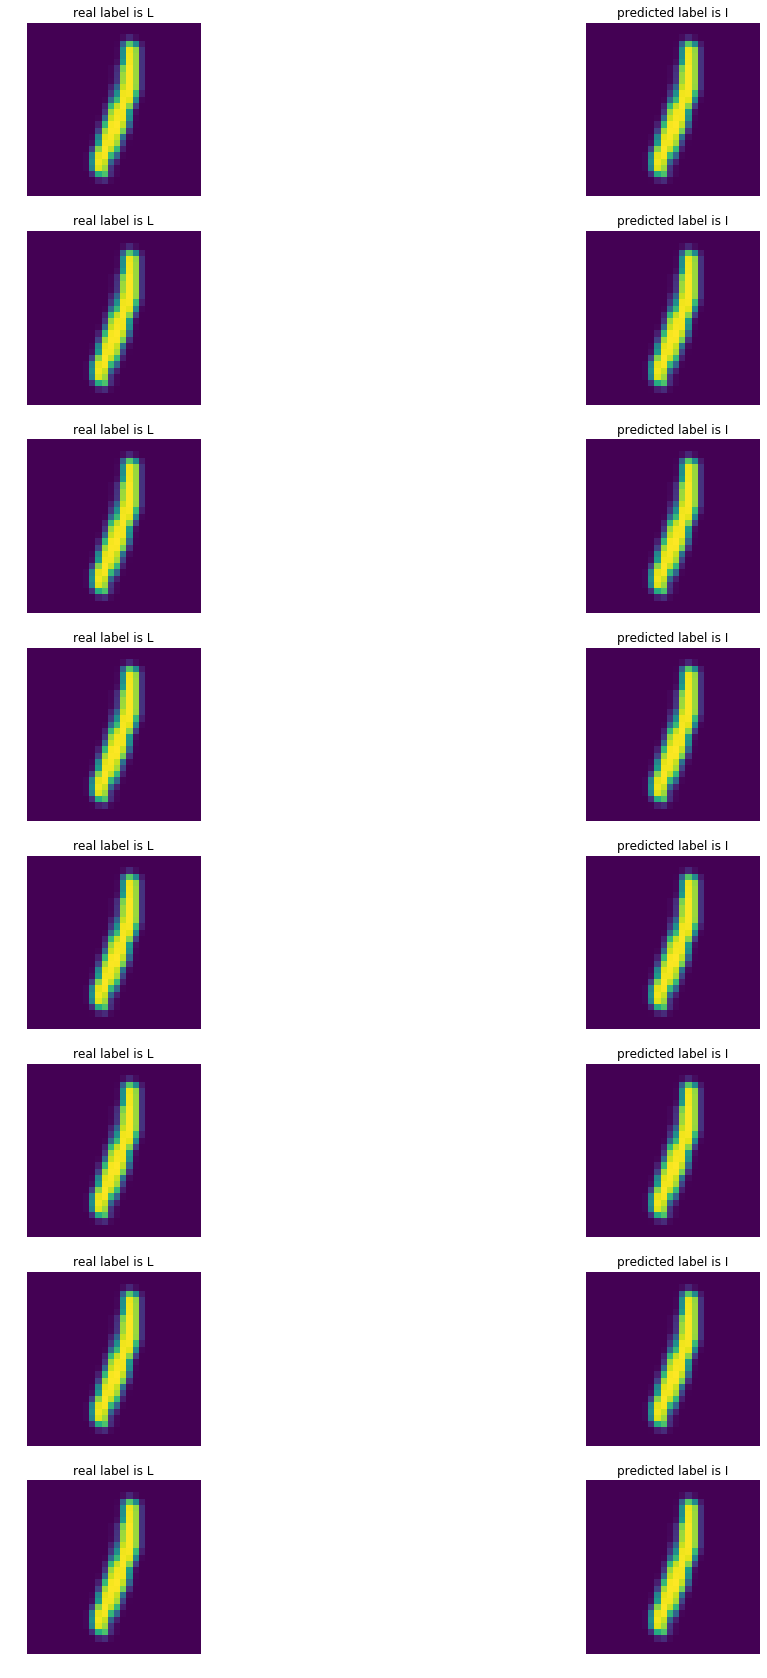

In [23]:
# get 8 random mis-classified index to display
display_index =[]
for i in range(8):
    n = random.randint(0,len(miscla_index))
    index = miscla_index[n]
    display_index.append(index)
print("displaying indexes are: ", display_index)

# display misclassification letters
fig, axs = plt.subplots(8,2, figsize=(20, 30))
fig.subplots_adjust(hspace = 0.20, wspace=.005)
axs = axs.ravel()
for i in range(8):
    for j,value in enumerate(display_index):
        image = x_test[value].squeeze()
        axs[2*i].axis('off')
        axs[2*i].imshow(image)
        axs[2*i].set_title('real label is {}'.format(y_labels[y_real_label[value]-1]))

        axs[2*i+1].axis('off')
        axs[2*i+1].imshow(image)
        axs[2*i+1].set_title('predicted label is {}'.format(y_labels[y_pred[value]-1]))
plt.show()

##### display some mis-classified images randomly (part 2)

displaying indexes are:  [8810, 5290, 19682, 9047, 5855, 5136, 8905, 6807]


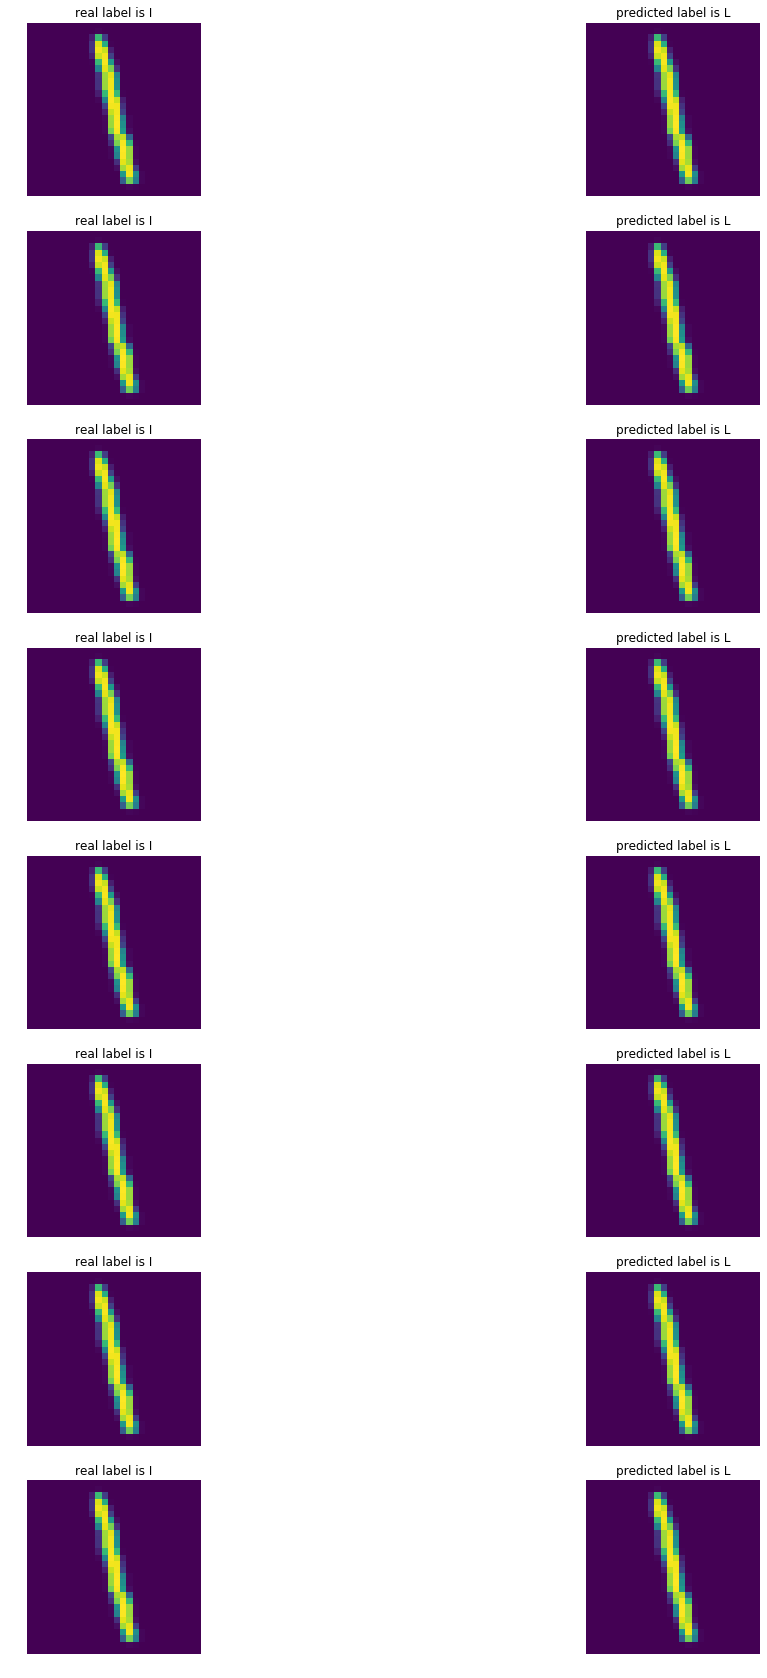

In [24]:
# get 8 random mis-classified index to display
display_index =[]
for i in range(8):
    n = random.randint(0,len(miscla_index))
    index = miscla_index[n]
    display_index.append(index)
print("displaying indexes are: ", display_index)

# display misclassification letters
fig, axs = plt.subplots(8,2, figsize=(20, 30))
fig.subplots_adjust(hspace = 0.20, wspace=.005)
axs = axs.ravel()
for i in range(8):
    for j,value in enumerate(display_index):
        image = x_test[value].squeeze()
        axs[2*i].axis('off')
        axs[2*i].imshow(image)
        axs[2*i].set_title('real label is {}'.format(y_labels[y_real_label[value]-1]))

        axs[2*i+1].axis('off')
        axs[2*i+1].imshow(image)
        axs[2*i+1].set_title('predicted label is {}'.format(y_labels[y_pred[value]-1]))
plt.show()

#### Q: Recall that EMNIST Letters merges upper- and lowercase letters into the same class. How might you design a network that accounts for that difference?

- Since there are upper and lower cases of letters, the features are doubled compared to just single type of letter (e.g. lower case letters). When we designed the network, we considered to employ twice of the convolutional layers as well as twice of the fully connected layers so that there are enough neorons to hold the features for both types of the letters.
- In our experiment below, we tested the theory of using a pair of convnets (2 convolutions layers) and pairs of fully connected layers (2 or 4 fully connected layers respectively) with twice nodes of the training on MNIST. It shows that with only several epochs, the training works very well. The test accuracy reached above 90% without applying too much regularizations.

In [27]:
#load dataset
mat = sio.loadmat('data/emnist-letters.mat')
data = mat['dataset']
# https://stackoverflow.com/questions/51125969/loading-emnist-letters-dataset/53547262#53547262
X_train = data['train'][0,0]['images'][0,0]
y_train = data['train'][0,0]['labels'][0,0]
X_test = data['test'][0,0]['images'][0,0]
y_test = data['test'][0,0]['labels'][0,0]
# reshape the data into 2D, 28x28 sized images instead of a 1D 784 array
# to get the correct image orientation, need to do a numpy reshape using Fortran ordering
# (Matlab uses column-major ordering, just like Fortran
# https://stackoverflow.com/questions/51125969/loading-emnist-letters-dataset/53547262#53547262
x_train = X_train.reshape((X_train.shape[0], 28, 28), order='F')
y_train = y_train.reshape(-1)
x_test = X_test.reshape((X_test.shape[0], 28, 28), order = 'F')   
y_test = y_test.reshape(-1)
# the data, split between train and validation sets
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size = 0.167, random_state = 0, shuffle=True)
# we want to have the same size for valid and test
print(x_train.shape,y_train.shape, x_valid.shape,y_valid.shape,x_test.shape,y_test.shape)

batch_size = 654
num_classes = 27 # the class label starts from 1-26, don't want to modify the label code, so apply a trick here
epochs = 5 #100
# input image dimensions
img_rows, img_cols = 28, 28

# TensorFlow's tensor expect the input shape (samples, rows, cols, channels) 
if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_valid = x_valid.reshape(x_valid.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_valid = x_valid.reshape(x_valid.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

# normalize the input data for reducing over-fitting
x_train = x_train.astype('float32')
x_valid = x_valid.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_valid /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')


# convert class vectors to ont hot encoding
y_train = keras.utils.to_categorical(y_train, num_classes,dtype='float32')
y_valid = keras.utils.to_categorical(y_valid, num_classes,dtype='float32')
y_test = keras.utils.to_categorical(y_test, num_classes,dtype='float32')

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(BatchNormalization(axis=-1))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization(axis=-1))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
# model.add(Dense(128, activation='relu'))
model.add(Dense(1568, activation='relu'))
model.add(BatchNormalization(axis=-1))
model.add(Dropout(0.5))
model.add(Dense(784, activation='relu'))
model.add(BatchNormalization(axis=-1))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])
tensorboard = TensorBoard(log_dir="logs_emnist_7/{}".format(time()))
# simple early stopping
es = EarlyStopping(monitor='accuracy', mode='max', verbose=1)
history= model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          callbacks=[tensorboard],
          validation_data=(x_valid, y_valid))

score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0]*100,'%')
print('Test accuracy:', score[1]*100,'%')
model.save('emnist_v7.h5')
print('saved model to disk')

# evaluate the model
_, train_acc = model.evaluate(x_train, y_train, verbose=0)
_, valid_acc = model.evaluate(x_valid, y_valid, verbose=0)
print('Train: %.3f, evaluate: %.3f' % (train_acc, valid_acc))

_, test_acc = model.evaluate(x_test, y_test, verbose=0)
print('Test: %.3f' % (test_acc))

(103958, 28, 28) (103958,) (20842, 28, 28) (20842,) (20800, 28, 28) (20800,)
x_train shape: (103958, 28, 28, 1)
103958 train samples
103958 train samples
20800 test samples
Train on 103958 samples, validate on 20842 samples
Epoch 1/5
103958/103958 [==============================] - 125s 1ms/step - loss: 0.5276 - acc: 0.8379 - val_loss: 0.2799 - val_acc: 0.9094
Epoch 2/5
103958/103958 [==============================] - 118s 1ms/step - loss: 0.2705 - acc: 0.9092 - val_loss: 0.2179 - val_acc: 0.9288
Epoch 3/5
103958/103958 [==============================] - 122s 1ms/step - loss: 0.2221 - acc: 0.9234 - val_loss: 0.2018 - val_acc: 0.9328
Epoch 4/5
103958/103958 [==============================] - 121s 1ms/step - loss: 0.1969 - acc: 0.9308 - val_loss: 0.2054 - val_acc: 0.9311
Epoch 5/5
103958/103958 [==============================] - 121s 1ms/step - loss: 0.1774 - acc: 0.9370 - val_loss: 0.1822 - val_acc: 0.9386
Test loss: 18.268253769555415 %
Test accuracy: 93.96634615384616 %
saved model to

## Summary of Results and Solutions

In [ ]:
#### Summary of parameters and hyper-parameters
- inspired by what Nelsen mentioned the paper in 2010 by Ciresan, Meier, Gambardella, and Schmidhuber they used 
only fully-connected layers (no convolutions). Here we used 2 convnet plus added more than 2 fully connected layers 
with many epoches (196) of training time.
- 0.5 dropout in between each fully connected layers;
- did not apply dropout to convolution layers since according to Nelsen, the convolutional layers have consideralbe
inbuilt resistance to overfitting.
- applied Batch normalization for each layer in between to solve the potential vanishing gradient problem and
potentially dead ReLu problem. 
- employed early stopping, it shows the network was keep learning so it did not reach to early stop settings,
but the number of datasets has been fully consumed (it stopped then)
- Used optimizer=keras.optimizers.Adadelta() rather than SGD in Keras. The advantage for Adadelta is it can 
automaticaly update learning rate adaptively of its learning rate according to loss function. 
- We tested on SGD with eta=0.03 which produced very low test accuracy.
- Expanded training dataset using Keras ImageDataGenerator() in MNIST dataset (see iteration 12). 
It did not help with model accuracy improvement. It might help in theory with the right parameters for data augmentation.
- The fully connected layers with dropout helps gradually reduce over-fitting (better performance than fewer layers high 
droput)
- added save the model to local disk to load in the future to re-produce the result
- Used Relu activation, but it might have dead ReLu problem according to Standard CNN class. It worthy to try Leaky Relu.
- displayed randome chosen mis-classified hand writing letters
- displayed accuracy and loss in TensorBoard
- relatively larger batch size helps with model performance.